In [1]:
# MODIFY! 
model_name = 'PoiReg'

# Import Libraries & Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/dl-pfe-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

In [6]:
# MODIFY!
from sklearn.linear_model import PoissonRegressor

model = PoissonRegressor()
model

PoissonRegressor()

In [7]:
alphas = np.linspace(0.1,1,10)

In [8]:
p_grid = {
    'alpha':alphas,
}

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
grid_model = GridSearchCV(
    estimator=model,
    param_grid =p_grid, 
    scoring='neg_mean_squared_error',
    cv=10, 
    verbose=1
)

In [11]:
grid_model.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished


GridSearchCV(cv=10, estimator=PoissonRegressor(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='neg_mean_squared_error', verbose=1)

In [12]:
grid_model.best_params_

{'alpha': 1.0}

In [13]:
hp = pd.Series(name=f'{model_name} HP', data=grid_model.best_params_)

In [14]:
hp

alpha    1.0
Name: PoiReg HP, dtype: float64

In [15]:
hp.to_csv(f'./hyperparameters/{model_name}-hp.csv')

# Score Model

In [16]:
# MODIFY! 
from sklearn.linear_model import PoissonRegressor

score_model = PoissonRegressor()
score_model

PoissonRegressor()

In [17]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [18]:
scores = pd.DataFrame(scores)

In [19]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.069212,0.002648,-3.198870,-16.421699,-4.052370
1,0.018467,0.001997,-3.518873,-20.039054,-4.476500
2,0.021525,0.001470,-3.174594,-17.993655,-4.241893
3,0.023858,0.001588,-3.472730,-18.963968,-4.354764
4,0.021538,0.001556,-3.205651,-16.934997,-4.115215
5,0.064289,0.002573,-3.723723,-23.625242,-4.860580
6,0.038360,0.002767,-3.264774,-17.802374,-4.219286
7,0.021947,0.001504,-3.166437,-15.730563,-3.966177
8,0.044175,0.001557,-2.800886,-13.870685,-3.724337
9,0.032634,0.003078,-2.989858,-16.194895,-4.024288


In [20]:
mean_scores = scores.mean()

In [21]:
mean_scores

fit_time                             0.035601
score_time                           0.002074
test_neg_mean_absolute_error        -3.251639
test_neg_mean_squared_error        -17.757713
test_neg_root_mean_squared_error    -4.203541
dtype: float64

# Export Scores

In [22]:
mean_scores = mean_scores.rename(f'{model_name}')

In [23]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [24]:
# mean_scores

In [25]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [26]:
mean_scores

Fit Time       0.035601
Score Time     0.002074
MAE            3.251639
MSE           17.757713
RMSE           4.203541
Name: PoiReg, dtype: float64

In [27]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [28]:
mean_scores

Fit Time       0.035601
Score Time     0.002074
MAE            3.251639
MSE           17.757713
RMSE           4.203541
STD FT         0.018428
STD ST         0.000627
STD MAE        0.265232
STD MSE        2.692947
STD RMSE       0.312616
Name: PoiReg, dtype: float64

In [29]:
mean_scores.to_csv(f'./scores/{model_name}-score.csv')

# Export Optimized Model

In [30]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

X_poi = scaler.transform(X)

poi_model = PoissonRegressor()
poi_model.fit(X_poi,y)

PoissonRegressor()

In [31]:
y_pred_poi = poi_model.predict(X_poi)

<AxesSubplot:ylabel='Count'>

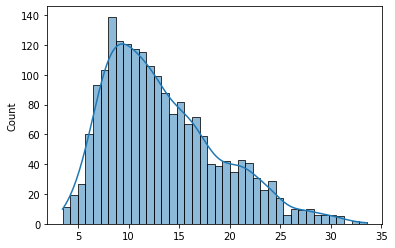

In [32]:
sns.histplot(y_pred_poi,bins=40,kde=True)

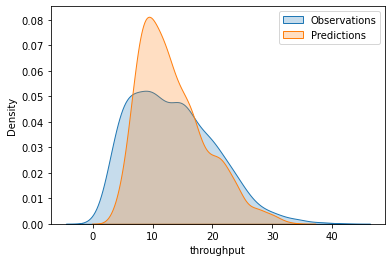

In [33]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred_poi, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

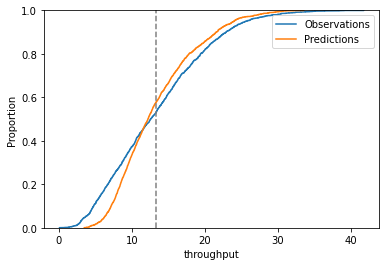

In [34]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred_poi, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y,y_pred_poi)
mse = mean_squared_error(y,y_pred_poi)
rmse = np.sqrt(mse)

In [36]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,PoiReg
MAE,3.072909
MSE,15.779219
RMSE,3.972306


In [39]:
err_df.to_csv(f'./model-err/{model_name}-err.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [38]:
from joblib import dump, load
dump(poi_model, f'./opt-models/{model_name}-model.joblib')

['./opt-models/PoiReg-model.joblib']

DONE!